# Link Video:https://drive.google.com/file/d/1Q4KPJ_d6aqKlMBXhUlTMaRmC2_4boIWk/view?usp=sharing

Nama: Lea Audrey
NIM: 2702261914

# GAN (Generative Adversarial Network)

In [1]:
import os
import zipfile
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tensorflow.keras import layers, models, optimizers
from scipy.linalg import sqrtm
from google.colab import files
from tensorflow.keras.applications.inception_v3 import preprocess_input

In [2]:
img_size = (100, 100)  # Resize
batch_size = 64

# Read File

In [3]:
# --- Extract Dataset ---
def extract_zip(zip_filename, extract_folder, folder_to_extract="A_23"):
    with zipfile.ZipFile(zip_filename, "r") as zip_ref:
        zip_contents = zip_ref.namelist()
        folder_found = [f for f in zip_contents if f.startswith(folder_to_extract)]
        if folder_found:
            zip_ref.extractall(extract_folder, members=folder_found)
            print(f"✅ Folder '{folder_to_extract}' dari {zip_filename} berhasil diekstrak ke {extract_folder}")
        else:
            print(f"❌ Folder '{folder_to_extract}' tidak ditemukan dalam {zip_filename}")

# Upload and extract data
uploaded = files.upload()
extract_folder = "/content/extracted_data"
os.makedirs(extract_folder, exist_ok=True)
for zip_filename in uploaded.keys():
    extract_zip(zip_filename, extract_folder)
data_folder = os.path.join(extract_folder, 'A_23')
assert os.path.exists(data_folder), "❌ Folder A_23 tidak ditemukan!"

# --- Split the dataset into training, validation, and testing sets ---
image_paths = [os.path.join(data_folder, fname) for fname in os.listdir(data_folder) if fname.lower().endswith(('.jpg', '.jpeg', '.png'))]

Saving A_23.zip to A_23 (1).zip
✅ Folder 'A_23' dari A_23 (1).zip berhasil diekstrak ke /content/extracted_data


### Jumlah image dalam dataset

In [12]:
print(f"Total number of images: {len(image_paths)}")

Total number of images: 1074


### Split Data

In [4]:
# Split paths into training, validation, and test sets
train_paths, test_paths = train_test_split(image_paths, test_size=0.2, random_state=42)
val_paths, test_paths = train_test_split(test_paths, test_size=0.5, random_state=42)

print(f"Jumlah data training: {len(train_paths)}")
print(f"Jumlah data validasi: {len(val_paths)}")
print(f"Jumlah data testing : {len(test_paths)}")

Jumlah data training: 859
Jumlah data validasi: 107
Jumlah data testing : 108


### Preprocessing

In [5]:
def load_and_normalize_image(path):
    img = tf.io.read_file(path)  # Read image from path
    img = tf.image.decode_jpeg(img, channels=3)  # RGB
    img = tf.image.resize(img, img_size)  # Resize  100x100
    img = img / 127.5 - 1.0  # Normalize to range [-1, 1]
    return img

# Convert  to TensorFlow dataset
def path_to_image_tensor(path):
    img = tf.numpy_function(func=load_and_normalize_image, inp=[path], Tout=tf.float32)
    img.set_shape([*img_size, 3])  # Set the shape explicitly
    return img

# Prepare TensorFlow Datasets
def prepare_dataset(image_paths):
    path_ds = tf.data.Dataset.from_tensor_slices(image_paths)
    image_ds = path_ds.map(path_to_image_tensor, num_parallel_calls=tf.data.AUTOTUNE)
    final_ds = image_ds.shuffle(buffer_size=len(image_paths))
    final_ds = final_ds.batch(batch_size)
    final_ds = final_ds.prefetch(tf.data.AUTOTUNE)
    return final_ds

train_ds = prepare_dataset(train_paths)
val_ds = prepare_dataset(val_paths)
test_ds = prepare_dataset(test_paths)

# FID
mengukur kualitas gambar yang dihasilkan oleh model Generative Adversarial Networks (GANs)

In [17]:
from tensorflow.keras.applications import InceptionV3

# load InceptionV3 model
def load_inception_model():
    inception_model = InceptionV3(include_top=False, pooling='avg', input_shape=(299, 299, 3))
    inception_model.trainable = False  # Freeze the model -> pakai feature extractor
    return inception_model

import numpy as np
import tensorflow as tf
from tensorflow.keras.applications.inception_v3 import preprocess_input
from scipy.linalg import sqrtm

# Calculate FID
def calculate_fid(real_images, generated_images, inception_model):
    real_images_resized = tf.image.resize(real_images, [299, 299]) # Resize -> karna inception menerima input 299x299
    generated_images_resized = tf.image.resize(generated_images, [299, 299]) # Resize

    # Preprocess
    real_images_resized = preprocess_input(tf.cast(real_images_resized, tf.float32))
    generated_images_resized = preprocess_input(tf.cast(generated_images_resized, tf.float32))

    # Get activations
    act1 = inception_model.predict(real_images_resized, verbose=0)
    act2 = inception_model.predict(generated_images_resized, verbose=0)

    # Mean and covariance of activations
    mu1, sigma1 = act1.mean(axis=0), np.cov(act1, rowvar=False)
    mu2, sigma2 = act2.mean(axis=0), np.cov(act2, rowvar=False)

    # Calculate FID
    ssdiff = np.sum((mu1 - mu2)**2)
    covmean = sqrtm(sigma1.dot(sigma2) + 1e-6 * np.eye(sigma1.shape[0]))

    if np.iscomplexobj(covmean):
        covmean = covmean.real

    fid = ssdiff + np.trace(sigma1 + sigma2 - 2 * covmean)
    return fid

# Baseline

## Generator

In [28]:
def build_generator(NOISE_DIM=100):
    model = models.Sequential(name="Generator")
    model.add(layers.Input(shape=(NOISE_DIM,)))

    # Fully connected layer
    model.add(layers.Dense(106 * 106 * 16)) # -> 106 × 106 × 16 = 179,536 unit
    model.add(layers.ReLU())

    # Mengubah vektor 1 dimensi menjadi 3D tensor berukuran 106 × 106 × 16.
    model.add(layers.Reshape((106, 106, 16)))

    # Konvolusi
    model.add(layers.Conv2D(16, kernel_size=3, strides=1, padding='valid', activation='relu')) # (104, 104, 16)

    model.add(layers.Conv2D(32, kernel_size=3, strides=1, padding='valid', activation='relu')) # (102, 102, 32)

    model.add(layers.Conv2D(64, kernel_size=3, strides=1, padding='valid', activation='relu')) # (100, 100, 64)

    # Ouput layer
    model.add(layers.Conv2D(3, kernel_size=1, strides=1, padding='same', activation='tanh'))
    return model

generator = build_generator()
generator.summary()

Model: "Generator"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_4 (Dense)                 │ (None, 179776)         │    18,157,376 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_1 (ReLU)                  │ (None, 179776)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape_2 (Reshape)             │ (None, 106, 106, 16)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_296 (Conv2D)             │ (None, 104, 104, 16)   │         2,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_297 (Conv2D)             │ (None, 102, 102, 32)   │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_298 (Conv2D)             │ (None, 100, 100, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_299 (Conv2D)             │ (None, 100, 100, 3)    │           195 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 18,183,027 (69.36 MB)

 Trainable params: 18,183,027 (69.36 MB)

 Non-trainable params: 0 (0.00 B)

## Discriminator

In [30]:
def build_discriminator(input_shape=(100, 100, 3)):
    model = models.Sequential(name="Discriminator")

    model.add(layers.Conv2D(16, kernel_size=3, strides=1, padding='valid', activation='relu', input_shape=input_shape)) # (98, 98, 16).
    model.add(layers.Conv2D(32, kernel_size=3, strides=1, padding='valid', activation='relu')) # (96, 96, 32)
    model.add(layers.Conv2D(64, kernel_size=3, strides=1, padding='valid', activation='relu')) # (94, 94, 64)

    model.add(layers.Flatten())
    model.add(layers.Dense(1, activation='sigmoid')) # menghasilkan nilai antara 0 dan 1
    return model

discriminator = build_discriminator()
discriminator.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "Discriminator"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_300 (Conv2D)             │ (None, 98, 98, 16)     │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_301 (Conv2D)             │ (None, 96, 96, 32)     │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_302 (Conv2D)             │ (None, 94, 94, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 565504)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 1)              │       565,505 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 589,089 (2.25 MB)

 Trainable params: 589,089 (2.25 MB)

 Non-trainable params: 0 (0.00 B)

## Optimizers

In [8]:
generator_baseline = build_generator()
discriminator_baseline = build_discriminator(input_shape=(100, 100, 3))

generator_optimizer = optimizers.Adam(1e-3)
discriminator_optimizer = optimizers.Adam(1e-3)

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


## Training GAN

In [14]:
# --- Training the GAN ---
gen_losses = []
disc_losses = []

@tf.function
def train_step(real_images):
    noise = tf.random.normal([batch_size, 100])  # Generate random noise
    with tf.GradientTape() as disc_tape, tf.GradientTape() as gen_tape:
        generated_images = generator_baseline(noise, training=True)

        real_output = discriminator_baseline(real_images, training=True)
        fake_output = discriminator_baseline(generated_images, training=True)

        gen_loss = tf.losses.BinaryCrossentropy(from_logits=True)(tf.ones_like(fake_output), fake_output)
        disc_loss = tf.losses.BinaryCrossentropy(from_logits=True)(tf.ones_like(real_output), real_output) + \
                    tf.losses.BinaryCrossentropy(from_logits=True)(tf.zeros_like(fake_output), fake_output)

    gradients_of_generator = gen_tape.gradient(gen_loss, generator_baseline.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator_baseline.trainable_variables)

    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator_baseline.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator_baseline.trainable_variables))

    return gen_loss, disc_loss

## Training

Epoch 1/200
Epoch 2/200
Epoch 3/200
Epoch 4/200
Epoch 5/200
Epoch 6/200
Epoch 7/200
Epoch 8/200
Epoch 9/200
Epoch 10/200
Epoch 11/200
Epoch 12/200
Epoch 13/200
Epoch 14/200
Epoch 15/200
Epoch 16/200
Epoch 17/200
Epoch 18/200
Epoch 19/200
Epoch 20/200
[Epoch 20] Avg Generator Loss: 2.6033, Avg Discriminator Loss: 0.9240
📉 FID Score (Epoch 20): 89.0754


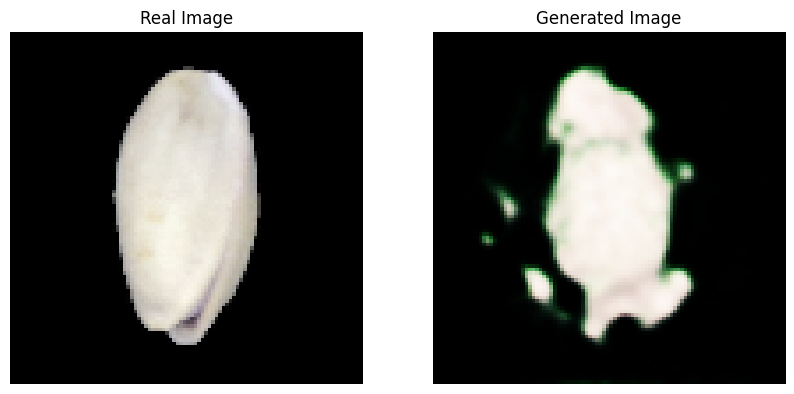

Epoch 21/200
Epoch 22/200
Epoch 23/200
Epoch 24/200
Epoch 25/200
Epoch 26/200
Epoch 27/200
Epoch 28/200
Epoch 29/200
Epoch 30/200
Epoch 31/200
Epoch 32/200
Epoch 33/200
Epoch 34/200
Epoch 35/200
Epoch 36/200
Epoch 37/200
Epoch 38/200
Epoch 39/200
Epoch 40/200
[Epoch 40] Avg Generator Loss: 1.8303, Avg Discriminator Loss: 0.7901
📉 FID Score (Epoch 40): 79.3461


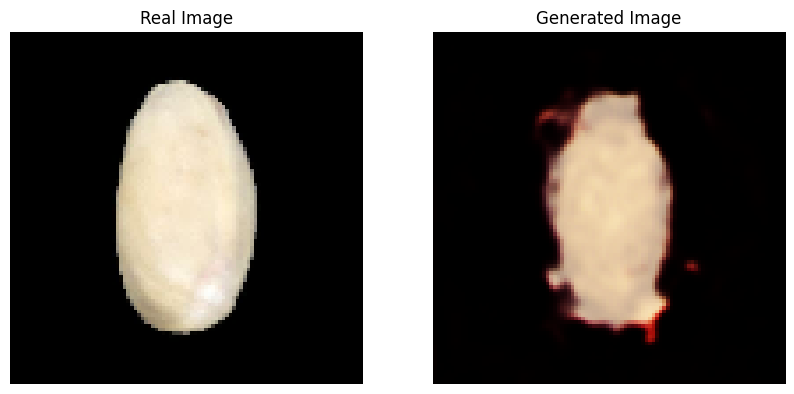

Epoch 41/200
Epoch 42/200
Epoch 43/200
Epoch 44/200
Epoch 45/200
Epoch 46/200
Epoch 47/200
Epoch 48/200
Epoch 49/200
Epoch 50/200
Epoch 51/200
Epoch 52/200
Epoch 53/200
Epoch 54/200
Epoch 55/200
Epoch 56/200
Epoch 57/200
Epoch 58/200
Epoch 59/200
Epoch 60/200
[Epoch 60] Avg Generator Loss: 1.5493, Avg Discriminator Loss: 0.7661
📉 FID Score (Epoch 60): 59.7588


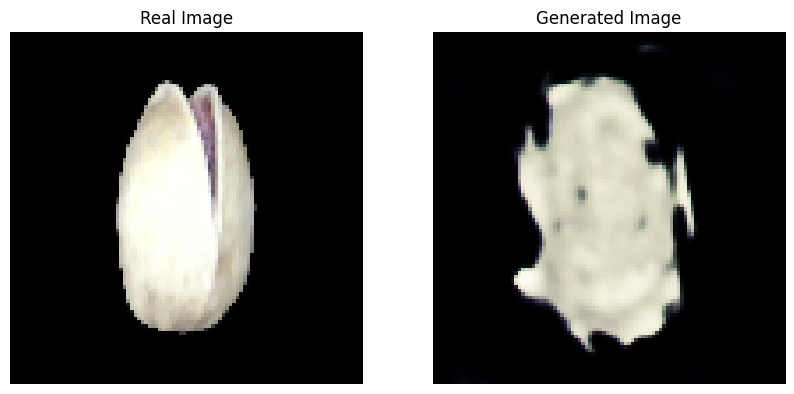

Epoch 61/200
Epoch 62/200
Epoch 63/200
Epoch 64/200
Epoch 65/200
Epoch 66/200
Epoch 67/200
Epoch 68/200
Epoch 69/200
Epoch 70/200
Epoch 71/200
Epoch 72/200
Epoch 73/200
Epoch 74/200
Epoch 75/200
Epoch 76/200
Epoch 77/200
Epoch 78/200
Epoch 79/200
Epoch 80/200
[Epoch 80] Avg Generator Loss: 1.7465, Avg Discriminator Loss: 0.6571
📉 FID Score (Epoch 80): 54.3646


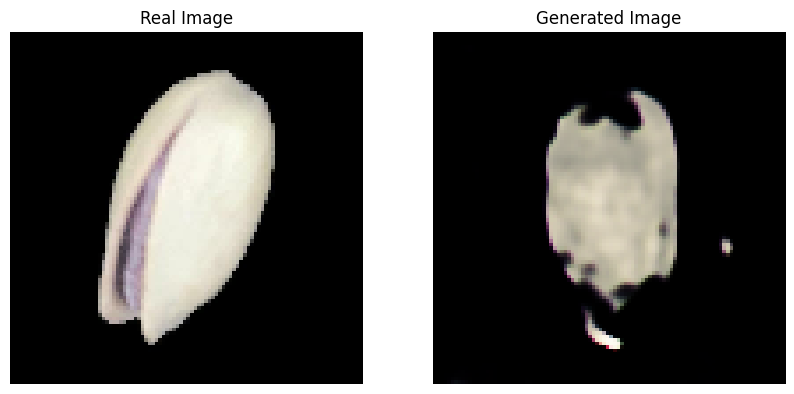

Epoch 81/200
Epoch 82/200
Epoch 83/200
Epoch 84/200
Epoch 85/200
Epoch 86/200
Epoch 87/200
Epoch 88/200
Epoch 89/200
Epoch 90/200
Epoch 91/200
Epoch 92/200
Epoch 93/200
Epoch 94/200
Epoch 95/200
Epoch 96/200
Epoch 97/200
Epoch 98/200
Epoch 99/200
Epoch 100/200
[Epoch 100] Avg Generator Loss: 1.2934, Avg Discriminator Loss: 0.8714
📉 FID Score (Epoch 100): 19.5986


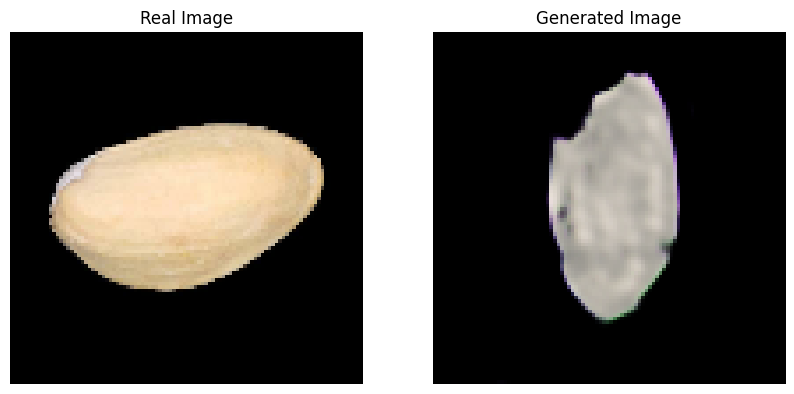

Epoch 101/200
Epoch 102/200
Epoch 103/200
Epoch 104/200
Epoch 105/200
Epoch 106/200
Epoch 107/200
Epoch 108/200
Epoch 109/200
Epoch 110/200
Epoch 111/200
Epoch 112/200
Epoch 113/200
Epoch 114/200
Epoch 115/200
Epoch 116/200
Epoch 117/200
Epoch 118/200
Epoch 119/200
Epoch 120/200
[Epoch 120] Avg Generator Loss: 1.2084, Avg Discriminator Loss: 1.2113
📉 FID Score (Epoch 120): 19.3484


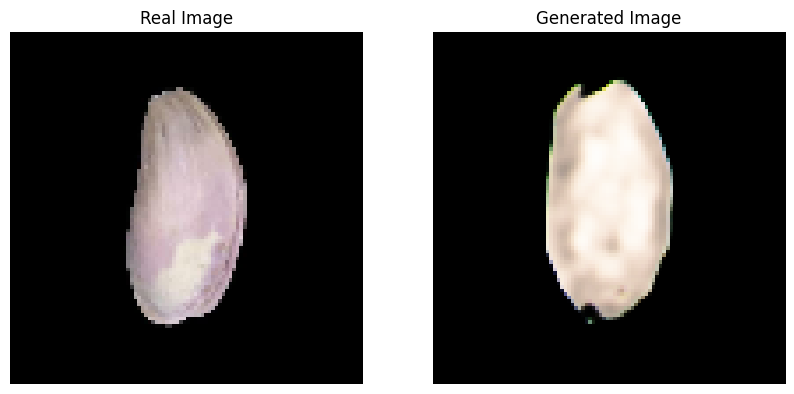

Epoch 121/200
Epoch 122/200
Epoch 123/200
Epoch 124/200
Epoch 125/200
Epoch 126/200
Epoch 127/200
Epoch 128/200
Epoch 129/200
Epoch 130/200
Epoch 131/200
Epoch 132/200
Epoch 133/200
Epoch 134/200
Epoch 135/200
Epoch 136/200
Epoch 137/200
Epoch 138/200
Epoch 139/200
Epoch 140/200
[Epoch 140] Avg Generator Loss: 1.3871, Avg Discriminator Loss: 0.8260
📉 FID Score (Epoch 140): 14.8430


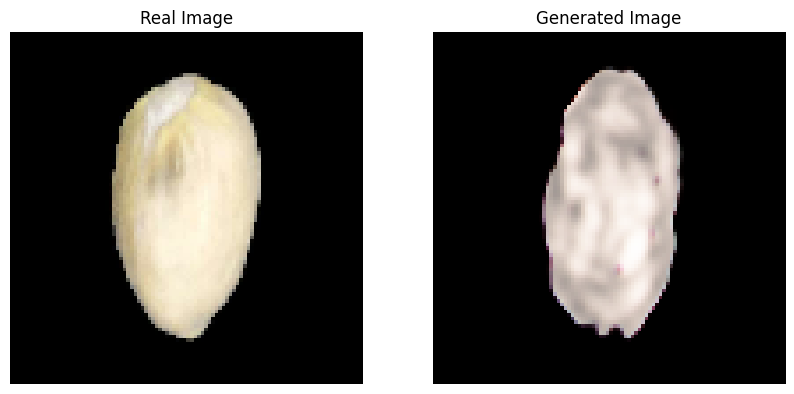

Epoch 141/200
Epoch 142/200
Epoch 143/200
Epoch 144/200
Epoch 145/200
Epoch 146/200
Epoch 147/200
Epoch 148/200
Epoch 149/200
Epoch 150/200
Epoch 151/200
Epoch 152/200
Epoch 153/200
Epoch 154/200
Epoch 155/200
Epoch 156/200
Epoch 157/200
Epoch 158/200
Epoch 159/200
Epoch 160/200
[Epoch 160] Avg Generator Loss: 1.0894, Avg Discriminator Loss: 1.3191
📉 FID Score (Epoch 160): 14.0464


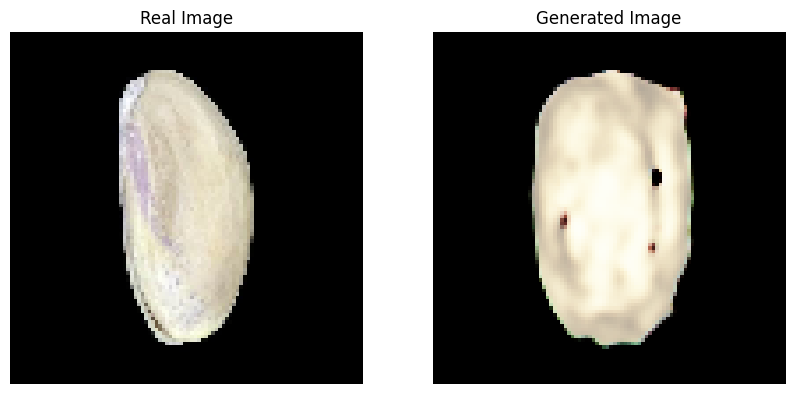

Epoch 161/200
Epoch 162/200
Epoch 163/200
Epoch 164/200
Epoch 165/200
Epoch 166/200
Epoch 167/200
Epoch 168/200
Epoch 169/200
Epoch 170/200
Epoch 171/200
Epoch 172/200
Epoch 173/200
Epoch 174/200
Epoch 175/200
Epoch 176/200
Epoch 177/200
Epoch 178/200
Epoch 179/200
Epoch 180/200
[Epoch 180] Avg Generator Loss: 1.5570, Avg Discriminator Loss: 0.7450
📉 FID Score (Epoch 180): 19.6550


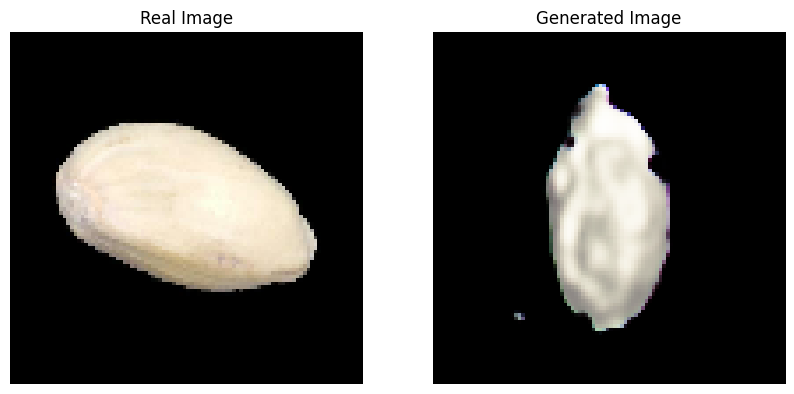

Epoch 181/200
Epoch 182/200
Epoch 183/200
Epoch 184/200
Epoch 185/200
Epoch 186/200
Epoch 187/200
Epoch 188/200
Epoch 189/200
Epoch 190/200
Epoch 191/200
Epoch 192/200
Epoch 193/200
Epoch 194/200
Epoch 195/200
Epoch 196/200
Epoch 197/200
Epoch 198/200
Epoch 199/200
Epoch 200/200
[Epoch 200] Avg Generator Loss: 1.2679, Avg Discriminator Loss: 0.9798
📉 FID Score (Epoch 200): 11.9393


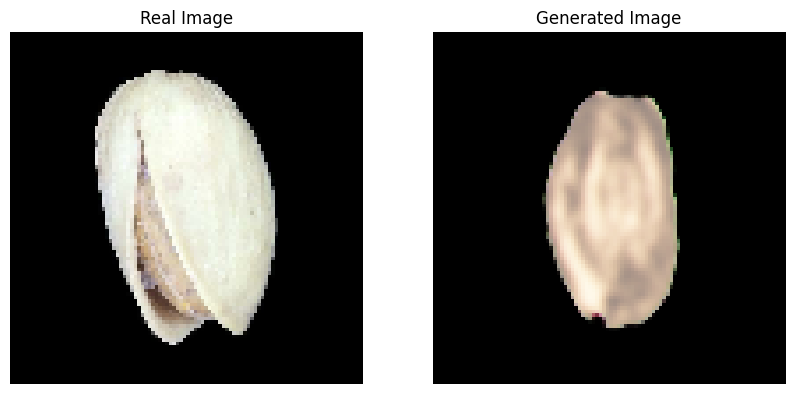

In [18]:
epochs = 200
fid_values = []
gen_losses = []
disc_losses = []

# Load InceptionV3 model
inception_model = load_inception_model()

for epoch in range(epochs):
    print(f"Epoch {epoch + 1}/{epochs}")

    # Store losses for each batch in each epoch
    gen_epoch_losses = []
    disc_epoch_losses = []

    for real_images_batch in train_ds:
        gen_loss, disc_loss = train_step(real_images_batch)
        gen_epoch_losses.append(gen_loss.numpy())
        disc_epoch_losses.append(disc_loss.numpy())

    # Average loss
    avg_gen_loss = np.mean(gen_epoch_losses)
    avg_disc_loss = np.mean(disc_epoch_losses)

    gen_losses.append(avg_gen_loss)
    disc_losses.append(avg_disc_loss)

    # per 20 epochs
    if (epoch + 1) % 20 == 0:
        print(f"[Epoch {epoch + 1}] Avg Generator Loss: {avg_gen_loss:.4f}, Avg Discriminator Loss: {avg_disc_loss:.4f}")

        # Calculate FID
        for real_images_batch in train_ds.take(1):
            noise = tf.random.normal([batch_size, 100])
            generated_images_batch = generator_baseline(noise, training=False)

            fid_value = calculate_fid(real_images_batch, generated_images_batch, inception_model)
            fid_values.append(fid_value)
            print(f"📉 FID Score (Epoch {epoch + 1}): {fid_value:.4f}")

            # Display images
            plt.figure(figsize=(10, 5))

            # Real Image
            plt.subplot(1, 2, 1)
            plt.imshow((real_images_batch[0] + 1) / 2)  # Normalize to [0, 1]
            plt.title("Real Image")
            plt.axis('off')

            # Generated Image
            plt.subplot(1, 2, 2)
            plt.imshow((generated_images_batch[0] + 1) / 2)  # Normalize to [0, 1]
            plt.title("Generated Image")
            plt.axis('off')

            plt.show()

## Plot Loss dan FID

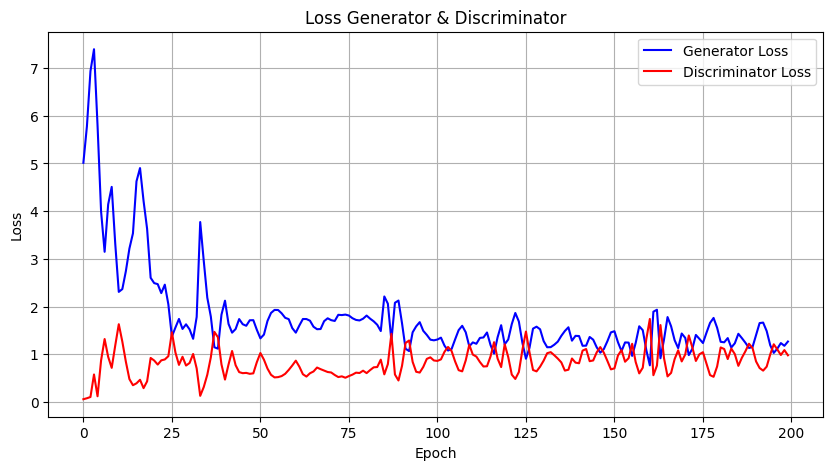

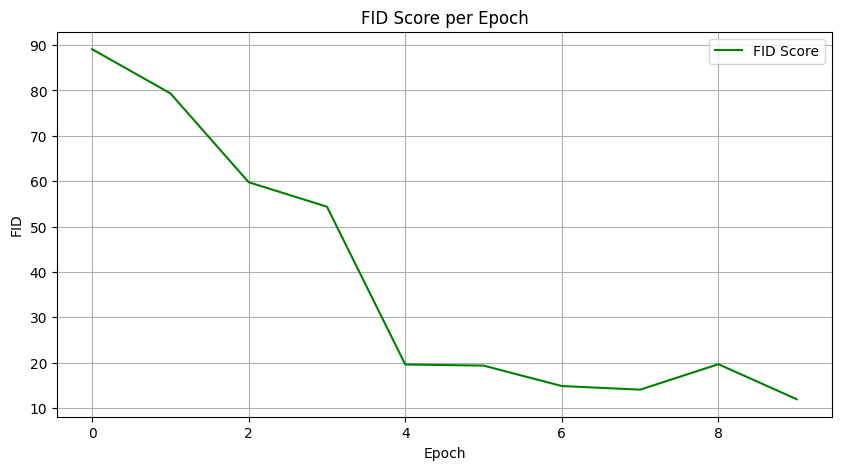

In [19]:
def plot_loss_and_fid(gen_losses, disc_losses, fid_values):
    # Plot Loss Generator & Discriminator
    plt.figure(figsize=(10, 5))
    plt.plot(gen_losses, label='Generator Loss', color='blue')
    plt.plot(disc_losses, label='Discriminator Loss', color='red')
    plt.title("Loss Generator & Discriminator")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()
    plt.grid(True)
    plt.show()

 # Plot FID
    plt.figure(figsize=(10, 5))
    plt.plot(fid_values, label='FID Score', color='green')
    plt.title("FID Score per Epoch")
    plt.xlabel("Epoch")
    plt.ylabel("FID")
    plt.legend()
    plt.grid(True)
    plt.show()

plot_loss_and_fid(gen_losses, disc_losses, fid_values)

## **perbandingan loss Generator dan Discriminator**:

* **Garis Biru**: **Generator Loss**.
* **Garis Merah**: **Discriminator Loss**.

#### 1. **Awal Training (Epoch 0–25)**:

* **Generator Loss (biru)** sangat tinggi dan fluktuatif — artinya model generator masih sangat buruk dalam menghasilkan gambar realistis.
* **Discriminator Loss (merah)** meningkat awalnya, lalu menurun tajam — menunjukkan bahwa discriminator cukup mudah membedakan gambar palsu dari nyata.

#### 2. **Epoch 25–100**:

* Generator mulai stabil dan menghasilkan gambar yang mulai bisa "menipu" discriminator.
* Generator Loss turun dan mulai konsisten di kisaran 1.5–2.

#### 3. **Epoch 100–200**:

* Kedua loss saling menyeimbangkan dalam kisaran **1.0–2.0**.

Sehingga
model menjadi lebih **stabil dan seimbang**, menandakan **GAN berhasil dilatih dengan baik**.
* Tidak ada indikasi **mode collapse** (generator loss tiba-tiba turun drastis menjadi 0 atau discriminator loss terlalu dominan).

##**FID Score per Epoch**
Perhitungannya tuh kalo  **FID < 50** → Umumnya dianggap sudah mulai menghasilkan gambar realistis.

1. **Awal Epoch (0–3)**:
   * FID score sangat tinggi (≈90 ke 55), artinya **gambar buatan masih sangat berbeda dari gambar nyata**.

2. **Epoch 4**:
   * Terjadi **penurunan FID drastis** ke sekitar 20

3. **Epoch 5–9**:
   * FID stabil dan rendah (sekitar 13–20).
   * Ini artinya **gambar buatan makin mendekati kualitas gambar asli**

In [20]:
# --- Printing Best FID and Loss Statistics ---
def print_best_fid_and_loss(fid_values, gen_losses, disc_losses):
    # Find the best FID and related epoch
    best_fid_idx = np.argmin(fid_values)  # Best FID is the smallest one
    best_fid = fid_values[best_fid_idx]
    best_fid_epoch = best_fid_idx + 1  # +1 because index starts from 0

    # Display statistics
    print(f"📈 Training Statistics:")
    print(f"  - Best FID: {best_fid:.4f} at Epoch {best_fid_epoch}")
    print(f"  - Average Generator Loss: {np.mean(gen_losses):.4f}")
    print(f"  - Average Discriminator Loss: {np.mean(disc_losses):.4f}")

# Call the function to display statistics
print_best_fid_and_loss(fid_values, gen_losses, disc_losses)

📈 Training Statistics:
  - Best FID: 11.9393 at Epoch 10
  - Average Generator Loss: 1.7778
  - Average Discriminator Loss: 0.8291


# Modifikasi

In [31]:
def build_generator_mod(NOISE_DIM=100):
    model = models.Sequential(name="Generator_Modified_V2")
    model.add(layers.Input(shape=(NOISE_DIM,)))
    model.add(layers.Dense(106 * 106 * 16))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU(0.2))
    model.add(layers.Reshape((106, 106, 16))) # Output: (106, 106, 16)

    # Layer Conv1 - Gambar lebih baik dengan lebih banyak filter
    model.add(layers.Conv2D(64, kernel_size=3, strides=1, padding='valid'))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU(0.2))
    # (104, 104, 64)

    # Layer Conv2
    model.add(layers.Conv2D(128, kernel_size=3, strides=1, padding='valid'))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU(0.2))
    # (102, 102, 128)

    # Layer Conv3
    model.add(layers.Conv2D(256, kernel_size=3, strides=1, padding='valid'))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU(0.2))
    # (100, 100, 256)

    # Layer Output (tanh)
    model.add(layers.Conv2D(3, kernel_size=1, strides=1, padding='same', activation='tanh'))
    return model
    # (100, 100, 3)

generator_mod = build_generator_mod()
generator_mod.summary()

Model: "Generator_Modified_V2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_6 (Dense)                 │ (None, 179776)         │    18,157,376 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_286         │ (None, 179776)         │       719,104 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_7 (LeakyReLU)       │ (None, 179776)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape_3 (Reshape)             │ (None, 106, 106, 16)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_303 (Conv2D)             │ (None, 104, 104, 64)   │         9,280 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_287         │ (None, 104, 104, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_8 (LeakyReLU)       │ (None, 104, 104, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_304 (Conv2D)             │ (None, 102, 102, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_288         │ (None, 102, 102, 128)  │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_9 (LeakyReLU)       │ (None, 102, 102, 128)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_305 (Conv2D)             │ (None, 100, 100, 256)  │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_289         │ (None, 100, 100, 256)  │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_10 (LeakyReLU)      │ (None, 100, 100, 256)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_306 (Conv2D)             │ (None, 100, 100, 3)    │           771 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 19,257,347 (73.46 MB)

 Trainable params: 18,896,899 (72.09 MB)

 Non-trainable params: 360,448 (1.38 MB)

In [33]:
def build_discriminator_mod(input_shape=(100, 100, 3)):

    model = models.Sequential(name="Discriminator_Modified_V2")
    model.add(layers.Conv2D(64, kernel_size=3, strides=1, padding='valid', input_shape=input_shape))
    model.add(layers.LeakyReLU(0.2)) # mencegah masalah vanishing gradient -> kali input negatif dengan 0,2
    model.add(layers.Dropout(0.4))
    # (98, 98, 64)

    model.add(layers.Conv2D(128, kernel_size=3, strides=1, padding='valid'))
    model.add(layers.LeakyReLU(0.2))
    model.add(layers.Dropout(0.4))
    # (96, 96, 128).

    model.add(layers.Conv2D(256, kernel_size=3, strides=1, padding='valid'))
    model.add(layers.LeakyReLU(0.2))
    model.add(layers.Dropout(0.4))
    # (94, 94, 256).

    model.add(layers.Flatten())
    model.add(layers.Dense(1, activation='sigmoid'))
    return model

discriminator_mod = build_discriminator_mod()
discriminator_mod.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "Discriminator_Modified_V2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_307 (Conv2D)             │ (None, 98, 98, 64)     │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_11 (LeakyReLU)      │ (None, 98, 98, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 98, 98, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_308 (Conv2D)             │ (None, 96, 96, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_12 (LeakyReLU)      │ (None, 96, 96, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 96, 96, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_309 (Conv2D)             │ (None, 94, 94, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_13 (LeakyReLU)      │ (None, 94, 94, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 94, 94, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_3 (Flatten)             │ (None, 2262016)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 1)              │     2,262,017 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,632,833 (10.04 MB)

 Trainable params: 2,632,833 (10.04 MB)

 Non-trainable params: 0 (0.00 B)

In [23]:
# --- Optimizer for Modified GAN ---
generator_mod = build_generator_mod()  # Generator mod
discriminator_mod = build_discriminator_mod(input_shape=(100, 100, 3))  # Discriminator mod

# Adam optimizer dengan learning rate 1e-4 dan beta_1 = 0.5
generator_optimizer_mod = optimizers.Adam(learning_rate=1e-4, beta_1=0.5, beta_2=0.999)  # Generator optimizer
discriminator_optimizer_mod = optimizers.Adam(learning_rate=1e-4, beta_1=0.5, beta_2=0.999)  # Discriminator optimizer

# beta_1: Mengatur momentum untuk gradien pertama (rata-rata bergerak dari gradien).
# beta_2: Mengatur varians dari gradien (rata-rata bergerak dari kuadrat gradien).

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [24]:
# --- Training the GAN ---
gen_losses_mod = []
disc_losses_mod = []
fid_values_mod = []

@tf.function
def train_step_mod(real_images):
    noise = tf.random.normal([batch_size, 100])  # Generate random noise
    with tf.GradientTape() as disc_tape, tf.GradientTape() as gen_tape:
        generated_images = generator_mod(noise, training=True)

        real_output = discriminator_mod(real_images, training=True)
        fake_output = discriminator_mod(generated_images, training=True)

        gen_loss = tf.losses.BinaryCrossentropy(from_logits=True)(tf.ones_like(fake_output), fake_output)
        disc_loss = tf.losses.BinaryCrossentropy(from_logits=True)(tf.ones_like(real_output), real_output) + \
                    tf.losses.BinaryCrossentropy(from_logits=True)(tf.zeros_like(fake_output), fake_output)

    gradients_of_generator = gen_tape.gradient(gen_loss, generator_mod.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator_mod.trainable_variables)

    generator_optimizer_mod.apply_gradients(zip(gradients_of_generator, generator_mod.trainable_variables))
    discriminator_optimizer_mod.apply_gradients(zip(gradients_of_discriminator, discriminator_mod.trainable_variables))

    return gen_loss, disc_loss

Epoch 1/200


/usr/local/lib/python3.11/dist-packages/keras/src/backend/tensorflow/nn.py:780: UserWarning: "`binary_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Sigmoid activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(
/usr/local/lib/python3.11/dist-packages/keras/src/backend/tensorflow/nn.py:780: UserWarning: "`binary_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Sigmoid activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(
/usr/local/lib/python3.11/dist-packages/keras/src/backend/tensorflow/nn.py:780: UserWarning: "`binary_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Sigmoid activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


Epoch 2/200
Epoch 3/200
Epoch 4/200
Epoch 5/200
Epoch 6/200
Epoch 7/200
Epoch 8/200
Epoch 9/200
Epoch 10/200
Epoch 11/200
Epoch 12/200
Epoch 13/200
Epoch 14/200
Epoch 15/200
Epoch 16/200
Epoch 17/200
Epoch 18/200
Epoch 19/200
Epoch 20/200
[Epoch 20] Avg Generator Loss: 1.0534, Avg Discriminator Loss: 1.1530
 FID Score (Epoch 20): 118.6619


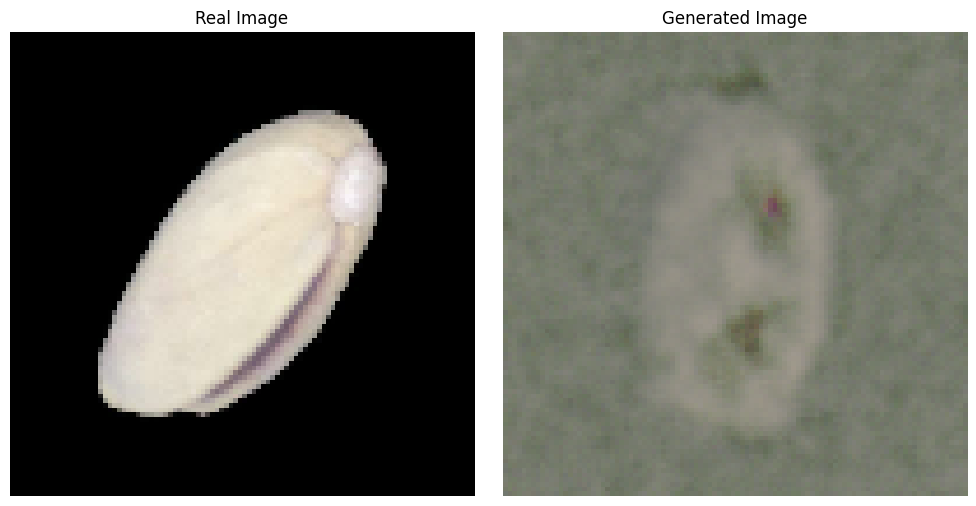

Epoch 21/200
Epoch 22/200
Epoch 23/200
Epoch 24/200
Epoch 25/200
Epoch 26/200
Epoch 27/200
Epoch 28/200
Epoch 29/200
Epoch 30/200
Epoch 31/200
Epoch 32/200
Epoch 33/200
Epoch 34/200
Epoch 35/200
Epoch 36/200
Epoch 37/200
Epoch 38/200
Epoch 39/200
Epoch 40/200
[Epoch 40] Avg Generator Loss: 0.9240, Avg Discriminator Loss: 1.0669
 FID Score (Epoch 40): 72.9196


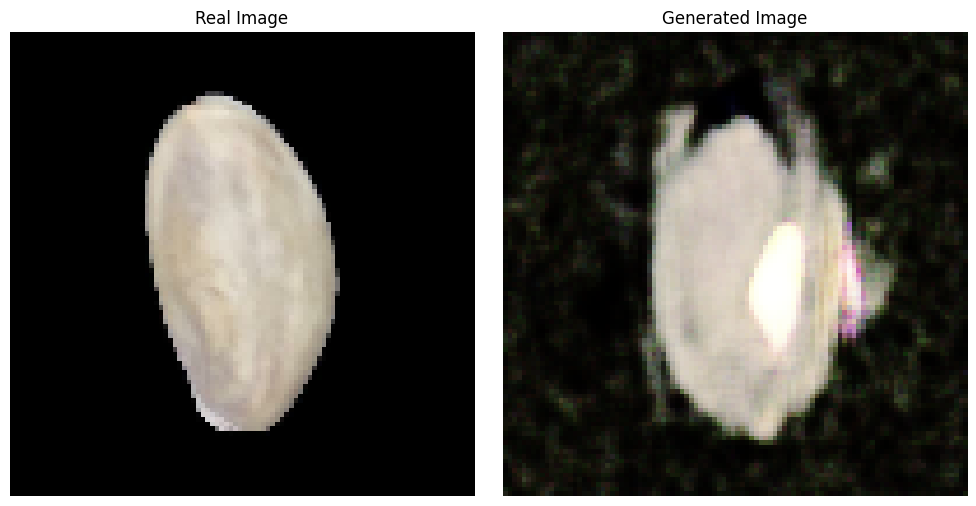

Epoch 41/200
Epoch 42/200
Epoch 43/200
Epoch 44/200
Epoch 45/200
Epoch 46/200
Epoch 47/200
Epoch 48/200
Epoch 49/200
Epoch 50/200
Epoch 51/200
Epoch 52/200
Epoch 53/200
Epoch 54/200
Epoch 55/200
Epoch 56/200
Epoch 57/200
Epoch 58/200
Epoch 59/200
Epoch 60/200
[Epoch 60] Avg Generator Loss: 0.8892, Avg Discriminator Loss: 1.2235
 FID Score (Epoch 60): 11.4980


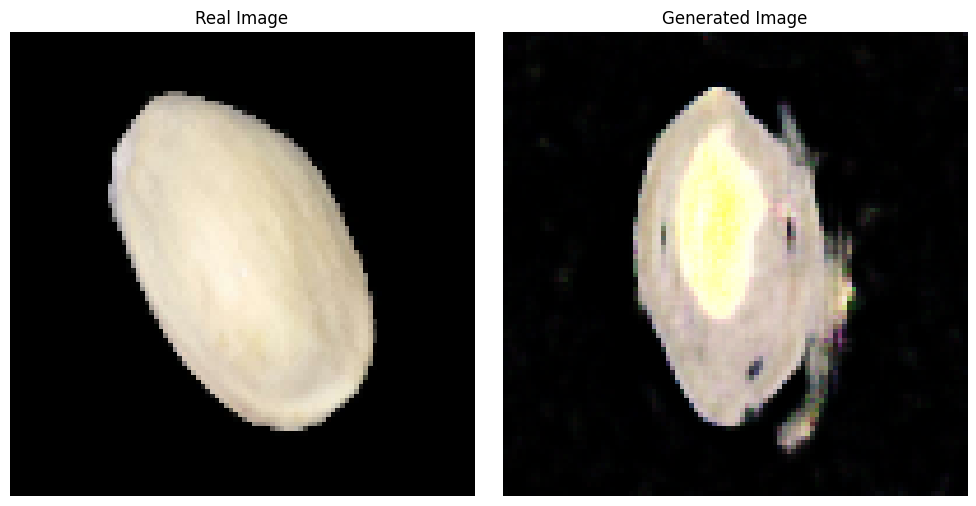

Epoch 61/200
Epoch 62/200
Epoch 63/200
Epoch 64/200
Epoch 65/200
Epoch 66/200
Epoch 67/200
Epoch 68/200
Epoch 69/200
Epoch 70/200
Epoch 71/200
Epoch 72/200
Epoch 73/200
Epoch 74/200
Epoch 75/200
Epoch 76/200
Epoch 77/200
Epoch 78/200
Epoch 79/200
Epoch 80/200
[Epoch 80] Avg Generator Loss: 0.8220, Avg Discriminator Loss: 1.2802
 FID Score (Epoch 80): 11.2234


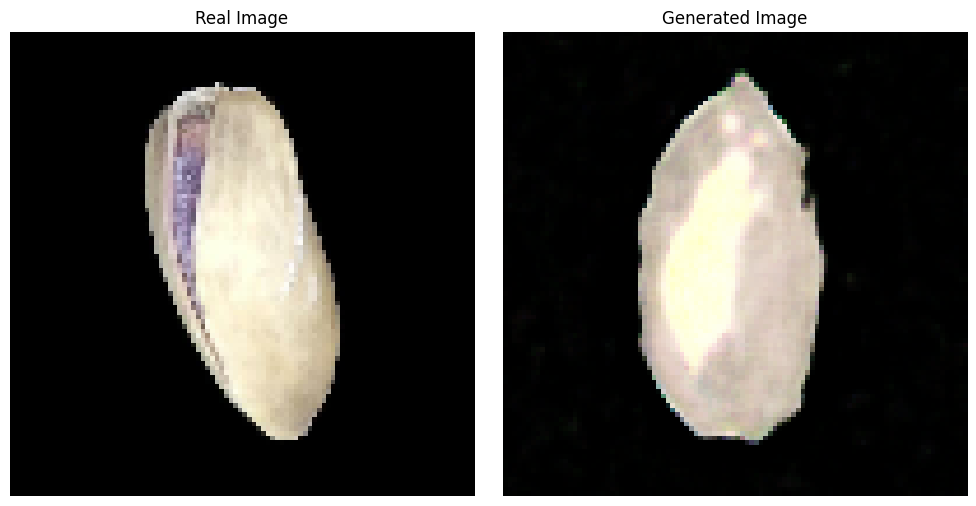

Epoch 81/200
Epoch 82/200
Epoch 83/200
Epoch 84/200
Epoch 85/200
Epoch 86/200
Epoch 87/200
Epoch 88/200
Epoch 89/200
Epoch 90/200
Epoch 91/200
Epoch 92/200
Epoch 93/200
Epoch 94/200
Epoch 95/200
Epoch 96/200
Epoch 97/200
Epoch 98/200
Epoch 99/200
Epoch 100/200
[Epoch 100] Avg Generator Loss: 0.8200, Avg Discriminator Loss: 1.2662
 FID Score (Epoch 100): 13.4193


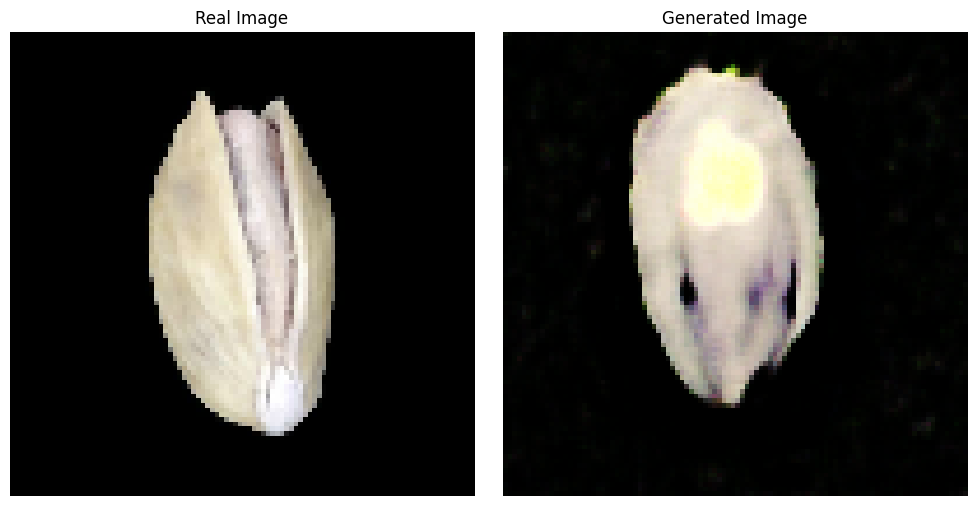

Epoch 101/200
Epoch 102/200
Epoch 103/200
Epoch 104/200
Epoch 105/200
Epoch 106/200
Epoch 107/200
Epoch 108/200
Epoch 109/200
Epoch 110/200
Epoch 111/200
Epoch 112/200
Epoch 113/200
Epoch 114/200
Epoch 115/200
Epoch 116/200
Epoch 117/200
Epoch 118/200
Epoch 119/200
Epoch 120/200
[Epoch 120] Avg Generator Loss: 0.8506, Avg Discriminator Loss: 1.2851
 FID Score (Epoch 120): 12.2832


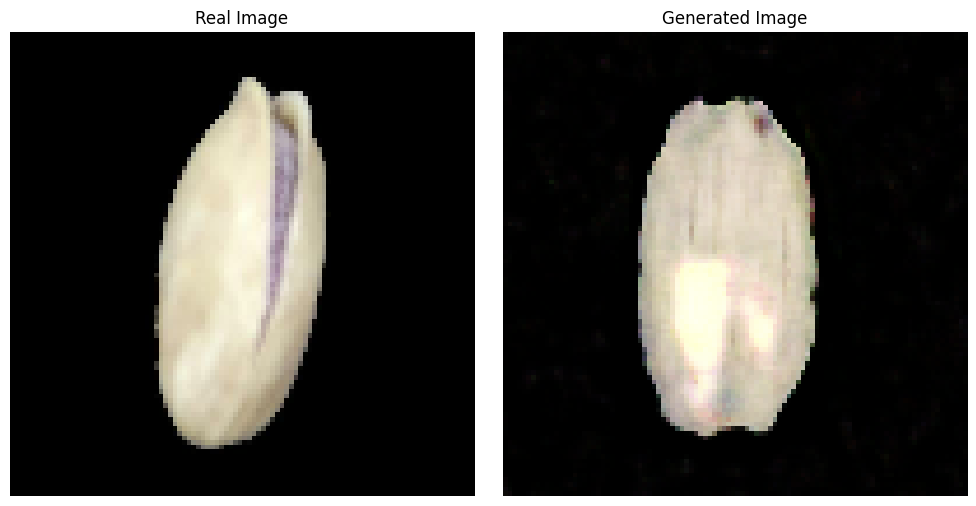

Epoch 121/200
Epoch 122/200
Epoch 123/200
Epoch 124/200
Epoch 125/200
Epoch 126/200
Epoch 127/200
Epoch 128/200
Epoch 129/200
Epoch 130/200
Epoch 131/200
Epoch 132/200
Epoch 133/200
Epoch 134/200
Epoch 135/200
Epoch 136/200
Epoch 137/200
Epoch 138/200
Epoch 139/200
Epoch 140/200
[Epoch 140] Avg Generator Loss: 0.8188, Avg Discriminator Loss: 1.2755
 FID Score (Epoch 140): 10.9836


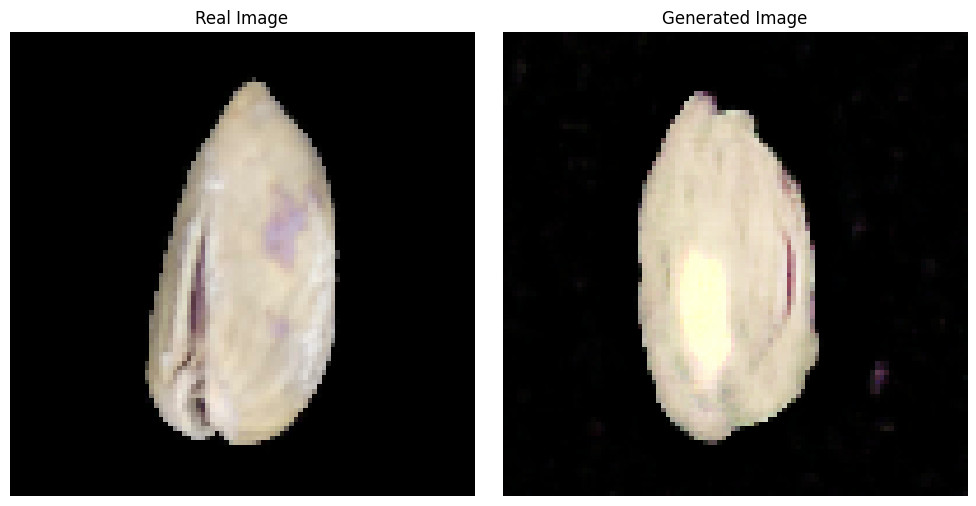

Epoch 141/200
Epoch 142/200
Epoch 143/200
Epoch 144/200
Epoch 145/200
Epoch 146/200
Epoch 147/200
Epoch 148/200
Epoch 149/200
Epoch 150/200
Epoch 151/200
Epoch 152/200
Epoch 153/200
Epoch 154/200
Epoch 155/200
Epoch 156/200
Epoch 157/200
Epoch 158/200
Epoch 159/200
Epoch 160/200
[Epoch 160] Avg Generator Loss: 0.8212, Avg Discriminator Loss: 1.3004
 FID Score (Epoch 160): 12.9444


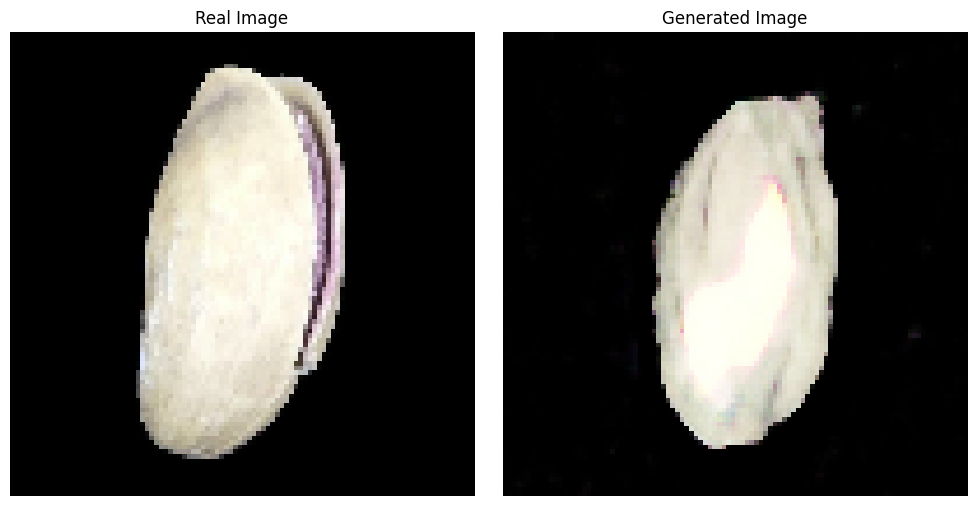

Epoch 161/200
Epoch 162/200
Epoch 163/200
Epoch 164/200
Epoch 165/200
Epoch 166/200
Epoch 167/200
Epoch 168/200
Epoch 169/200
Epoch 170/200
Epoch 171/200
Epoch 172/200
Epoch 173/200
Epoch 174/200
Epoch 175/200
Epoch 176/200
Epoch 177/200
Epoch 178/200
Epoch 179/200
Epoch 180/200
[Epoch 180] Avg Generator Loss: 0.8043, Avg Discriminator Loss: 1.2934
 FID Score (Epoch 180): 11.2947


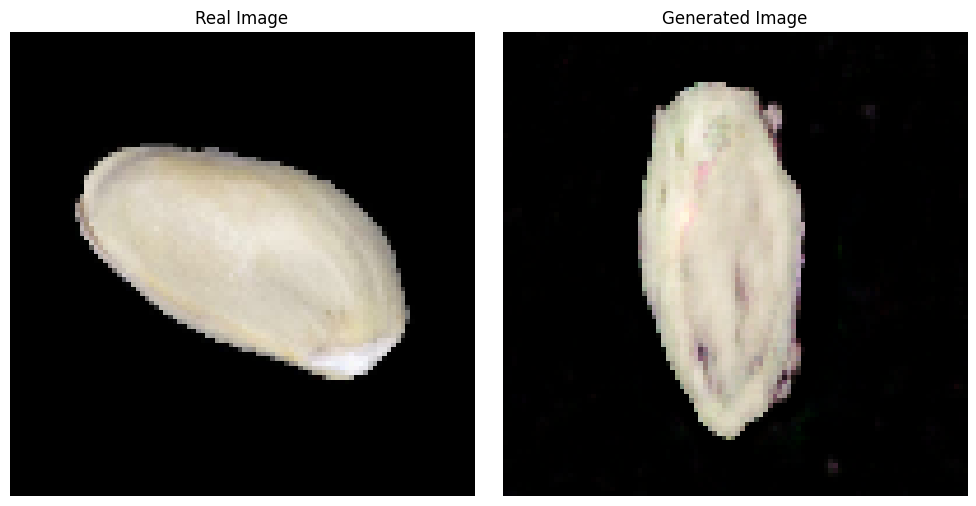

Epoch 181/200
Epoch 182/200
Epoch 183/200
Epoch 184/200
Epoch 185/200
Epoch 186/200
Epoch 187/200
Epoch 188/200
Epoch 189/200
Epoch 190/200
Epoch 191/200
Epoch 192/200
Epoch 193/200
Epoch 194/200
Epoch 195/200
Epoch 196/200
Epoch 197/200
Epoch 198/200
Epoch 199/200
Epoch 200/200
[Epoch 200] Avg Generator Loss: 0.7910, Avg Discriminator Loss: 1.2894
 FID Score (Epoch 200): 11.8739


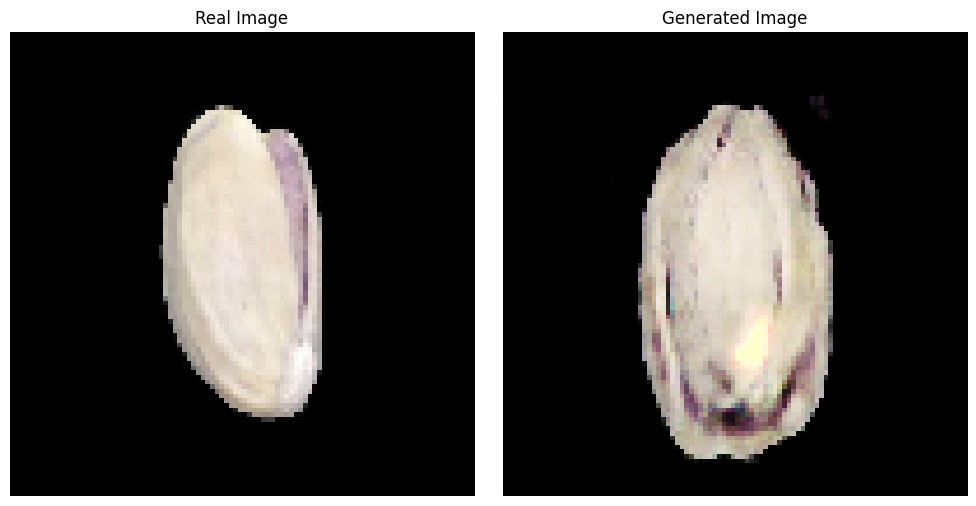

In [25]:
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf

epochs = 200
batch_size = 64

# Load InceptionV3
inception_model = load_inception_model()

# Training loop
for epoch in range(epochs):
    print(f"Epoch {epoch + 1}/{epochs}")

    gen_epoch_losses = []
    disc_epoch_losses = []

    for real_images_batch in train_ds:
        try:
            gen_loss, disc_loss = train_step_mod(real_images_batch)
            gen_epoch_losses.append(gen_loss.numpy())
            disc_epoch_losses.append(disc_loss.numpy())
        except Exception as e:
            print(f"❗ Error during training step: {e}")
            continue

    # Hitung rata-rata loss untuk epoch ini
    avg_gen_loss = np.mean(gen_epoch_losses)
    avg_disc_loss = np.mean(disc_epoch_losses)

    gen_losses_mod.append(avg_gen_loss)
    disc_losses_mod.append(avg_disc_loss)


    # Display FID dan gambar tiap 20 epoch
    if (epoch + 1) % 20 == 0:
        print(f"[Epoch {epoch + 1}] Avg Generator Loss: {avg_gen_loss:.4f}, Avg Discriminator Loss: {avg_disc_loss:.4f}")

        try:
            real_images_example = next(iter(train_ds.take(1)))
            noise = tf.random.normal([batch_size, 100])
            generated_images = generator_mod(noise, training=False)

            # Hitung FID
            fid = calculate_fid(real_images_example, generated_images, inception_model)
            fid_values_mod.append(fid)
            print(f" FID Score (Epoch {epoch + 1}): {fid:.4f}")

            # Tampilkan gambar real vs generated
            plt.figure(figsize=(10, 5))

            plt.subplot(1, 2, 1)
            plt.imshow((real_images_example[0] + 1) / 2)  # Normalisasi ke [0, 1]
            plt.title("Real Image")
            plt.axis('off')

            plt.subplot(1, 2, 2)
            plt.imshow((generated_images[0] + 1) / 2)
            plt.title("Generated Image")
            plt.axis('off')

            plt.tight_layout()
            plt.show()

        except Exception as e:
            print(f"❗ Error during FID or plotting at Epoch {epoch + 1}: {e}")


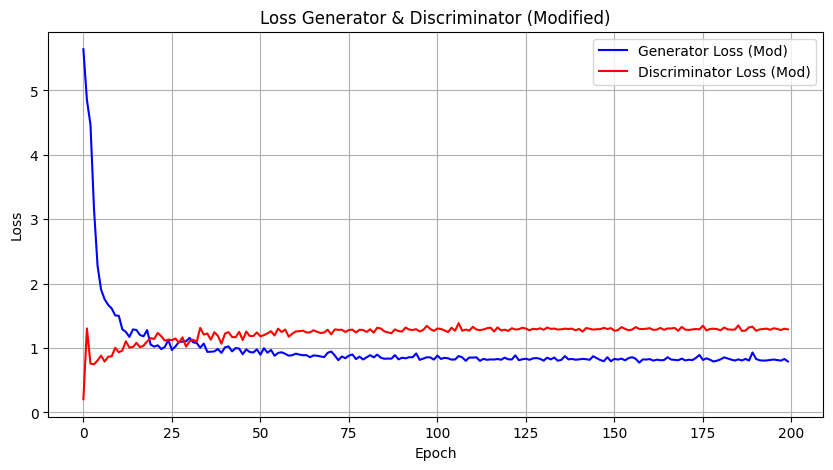

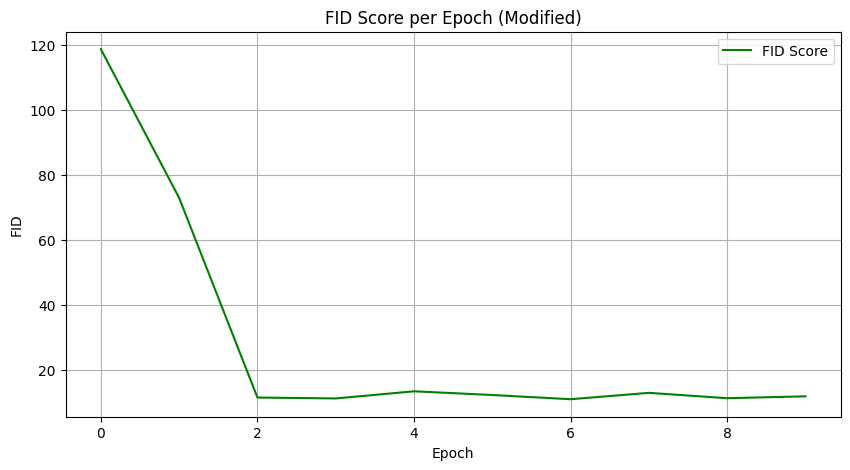

In [26]:
# --- Plotting Loss and FID ---
def plot_loss_and_fid(gen_losses_mod, disc_losses_mod, fid_values_mod):
    # Plot Generator & Discriminator Loss
    plt.figure(figsize=(10, 5))
    plt.plot(gen_losses_mod, label='Generator Loss (Mod)', color='blue')
    plt.plot(disc_losses_mod, label='Discriminator Loss (Mod)', color='red')
    plt.title("Loss Generator & Discriminator (Modified)")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()
    plt.grid(True)
    plt.show()

    # Plot FID
    plt.figure(figsize=(10, 5))
    plt.plot(fid_values_mod, label='FID Score', color='green')
    plt.title("FID Score per Epoch (Modified)")
    plt.xlabel("Epoch")
    plt.ylabel("FID")
    plt.legend()
    plt.grid(True)
    plt.show()

# Call the plot function
plot_loss_and_fid(gen_losses_mod, disc_losses_mod, fid_values_mod)

## **perbandingan loss Generator dan Discriminator**:

* **Garis Biru** = *Generator Loss (Mod)*
* **Garis Merah** = *Discriminator Loss (Mod)*


1. **Generator Loss (biru)**:
   * Awalnya tinggi (sekitar >5), lalu **turun drastis** dalam 20–30 epoch pertama.
   * Setelah itu, stabil di sekitar **0.8 – 1.0** → artinya generator sudah cukup belajar menghasilkan gambar yang bisa mengecoh discriminator.

2. **Discriminator Loss (merah)**:
   * Awalnya fluktuatif → mungkin karena learning phase awal saat real vs fake masih mudah dibedakan.
   * Mulai stabil setelah epoch ke-30-an dan bertahan di sekitar **1.2 – 1.3**.
  


## **FID per Epoch**.

1. **Penurunan tajam di awal**:

   * Dari \~118 ke \~12 hanya dalam 3×20 epoch (60 epoch).
   * model belajar cepat menghasilkan gambar lebih realistis.

2. **Stabil setelah epoch ke-60**:

   * Fluktuasi kecil antara **11–14**, menandakan **kualitas sudah optimal dan konsisten**.
   * Ini selaras dengan **loss generator & discriminator** yang sudah stabil di grafik sebelumnya.

3. **Tidak ada overfitting atau degradasi kualitas visual**:
   * FID tidak naik tajam di akhir (indikasi kualitas gambar tetap bagus hingga akhir training).

In [27]:
# --- Function to print best FID and Loss Statistics ---
def print_best_fid_and_loss(fid_values_mod, gen_losses_mod, disc_losses_mod):
    # Menemukan FID terbaik dan epoch terkait
    best_fid_idx = np.argmin(fid_values_mod)  # FID terbaik adalah yang terkecil
    best_fid = fid_values_mod[best_fid_idx]
    best_fid_epoch = best_fid_idx + 1  # +1 karena indeks dimulai dari 0

    # Menampilkan statistik
    print(f"📈 Statistik Pelatihan (Modified):")
    print(f"  - FID Terbaik: {best_fid:.4f} pada Epoch {best_fid_epoch}")
    print(f"  - Rata-rata Generator Loss: {np.mean(gen_losses_mod):.4f}")
    print(f"  - Rata-rata Discriminator Loss: {np.mean(disc_losses_mod):.4f}")

# --- Memanggil Fungsi untuk Menampilkan Statistik ---
print_best_fid_and_loss(fid_values_mod, gen_losses_mod, disc_losses_mod)

📈 Statistik Pelatihan (Modified):
  - FID Terbaik: 10.9836 pada Epoch 7
  - Rata-rata Generator Loss: 0.9915
  - Rata-rata Discriminator Loss: 1.2319


# Evaluasi Akhir

###  **Perbandingan Statistik Pelatihan**

| Metrik                           |  Statistik Pelatihan (Modified) |  Training Statistics (Awal) | Kesimpulan                                                           |
| -------------------------------- | --------------------------------- | ----------------------------- | -------------------------------------------------------------------- |
| **FID Terbaik**                  |  **10.9836** (Epoch 7)           | 11.9393 (Epoch 10)            | **Lebih baik** setelah modifikasi                                    |
| **Rata-rata Generator Loss**     |  **0.9915**                      | 1.7778                        | **Lebih rendah**, artinya Generator lebih stabil                     |
| **Rata-rata Discriminator Loss** |  **1.2319**                     | 0.8291                        | **Lebih tinggi**, Discriminator lebih sering terkecoh oleh Generator |


### **Modified Lebih Baik:**

1. **FID lebih rendah (10.98 vs 11.93)** → hasil gambar lebih realistis.
2. **Generator Loss lebih rendah (0.99 vs 1.77)** → Generator lebih stabil & efisien.
3. **Discriminator Loss memang naik (1.23 vs 0.82)**, tapi ini bisa jadi **indikasi bahwa Generator berhasil mengecoh Discriminator lebih sering**, artinya Generator makin kuat.

# **lebih unggul** karena menghasilkan gambar yang lebih realistis dan stabil.
